In [1]:
import lightgbm as lgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query


from sm_utils import sampling, evaluate, save_model, load_model
from sm_utils import make_train_data,  make_test_data, df_to_md_table

In [2]:
DATA_PATH = '/home/dmig/work/upsell/data/'

In [3]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

## load data

In [4]:
df_mart08 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201908.pkl'))

In [5]:
# make train data
result = make_train_data(df_mart08)

trn_idx = result['trn']['idx']
x_trn = result['trn']['x']
y_trn = result['trn']['y']

val_idx = result['val']['idx']
x_val = result['val']['x']
y_val = result['val']['y']

feature_cols = list(x_trn.columns)

lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

make_train_data +++
label/sample:  0.2
sample/total:  0.10345684777543288
make_data_for_modeling---


In [6]:
clf= load_model('dominic_lgbm_20191011')

load model from  dominic_lgbm_20191011


## shap

In [7]:
from shap_tools import ShapModule

In [12]:
sm = ShapModule(df_mart08, clf, feature_cols, 'svc_mgmt_num', 'label', label_dict={0:0, 1:1})

init!
<class 'lightgbm.basic.Booster'>


In [13]:
sm.calculate_shap_value()

elapsed time:  88.5591151714325


In [22]:
clf.predict(sm.sample_df.head()[feature_cols])

array([0.24663862, 0.10218946, 0.14398752, 0.77421532, 0.17616268])

In [29]:
sm.force_plot_custom()

calculate predict score by your self
model prediction score is : 0.0 
real target value was [0]


In [30]:
df_sv = pd.DataFrame(sm.shap_value[1], columns=sm.feature_cols, index=sm.sample_df.index)

In [35]:
clf.predict(sm.sample_df.head(10)[feature_cols])

array([0.24663862, 0.10218946, 0.14398752, 0.77421532, 0.17616268,
       0.25036605, 0.01323292, 0.73978948, 0.09182797, 0.48687916])

In [36]:
df_sv['prob'] = clf.predict(sm.sample_df[feature_cols])

In [38]:
df_sv.head()

sex_cd       age    svc_gr  mng_nice_cb_scr  mng_nice_cb_grd  \
svc_mgmt_num                                                                   
7290234760   -0.126692  0.147603 -0.034964        -0.002588         0.022044   
7294118735   -0.108965 -0.271566 -0.032197         0.199645         0.218071   
7276845188   -0.020326 -0.828688 -0.045293        -0.009023        -0.040056   
7296866635    0.100540  0.135075 -0.036674         0.022442         0.004437   
7215900596    0.105926 -0.187802 -0.058839        -0.105511        -0.034133   

              svc_scrb_period  last_equip_period  bas_fee_amt  \
svc_mgmt_num                                                    
7290234760          -0.053442          -0.013680     0.140517   
7294118735          -0.054461          -0.336261     0.262154   
7276845188          -0.067854           0.401543     0.038136   
7296866635           0.087405          -0.261298     0.245378   
7215900596           0.023797          -1.079148    -0.030477   

              bas_ofr_data_gb  eqp_out_prc  ...  mth_cnsl_cnt_bf_m1  \
svc_mgmt_num                                ...                       
7290234760          -0.213461          0.0  ...           -0.006226   
7294118735          -0.180796          0.0  ...           -0.006736   
7276845188           0.053170          0.0  ...           -0.004331   
7296866635           0.012610          0.0  ...           -0.004636   
7215900596          -0.144109          0.0  ...            0.016834   

              mth_cnsl_cnt_bf_m2  dsat_cnsl_cnt_bf_m0  dsat_cnsl_cnt_bf_m1  \
svc_mgmt_num                                                                 
7290234760             -0.011031             0.000423             0.000512   
7294118735             -0.012684             0.000189             0.000349   
7276845188             -0.010078             0.001206             0.000747   
7296866635             -0.009143             0.000581             0.000406   
7215900596              0.054245             0.000747             0.000906   

              dsat_cnsl_cnt_bf_m2  simpl_ref_cnsl_cnt_bf_m0  \
svc_mgmt_num                                                  
7290234760               0.000068                 -0.010613   
7294118735               0.000069                 -0.011536   
7276845188               0.000002                 -0.007007   
7296866635              -0.000007                 -0.015719   
7215900596              -0.000111                  0.113156   

              simpl_ref_cnsl_cnt_bf_m1  simpl_ref_cnsl_cnt_bf_m2   channel  \
svc_mgmt_num                                                                 
7290234760                   -0.014822                 -0.003360  0.093497   
7294118735                   -0.016478                 -0.004083 -0.026958   
7276845188                   -0.014074                 -0.001763  0.069720   
7296866635                   -0.014321                 -0.004990 -0.037210   
7215900596                    0.083702                  0.014300  0.051913   

                  prob  
svc_mgmt_num            
7290234760    0.246639  
7294118735    0.102189  
7276845188    0.143988  
7296866635    0.774215  
7215900596    0.176163  

[5 rows x 80 columns]

In [39]:
df_tmp = df_sv.reset_index()

In [40]:
df_tmp.head()

svc_mgmt_num    sex_cd       age    svc_gr  mng_nice_cb_scr  \
0   7290234760 -0.126692  0.147603 -0.034964        -0.002588   
1   7294118735 -0.108965 -0.271566 -0.032197         0.199645   
2   7276845188 -0.020326 -0.828688 -0.045293        -0.009023   
3   7296866635  0.100540  0.135075 -0.036674         0.022442   
4   7215900596  0.105926 -0.187802 -0.058839        -0.105511   

   mng_nice_cb_grd  svc_scrb_period  last_equip_period  bas_fee_amt  \
0         0.022044        -0.053442          -0.013680     0.140517   
1         0.218071        -0.054461          -0.336261     0.262154   
2        -0.040056        -0.067854           0.401543     0.038136   
3         0.004437         0.087405          -0.261298     0.245378   
4        -0.034133         0.023797          -1.079148    -0.030477   

   bas_ofr_data_gb  ...  mth_cnsl_cnt_bf_m1  mth_cnsl_cnt_bf_m2  \
0        -0.213461  ...           -0.006226           -0.011031   
1        -0.180796  ...           -0.006736           -0.012684   
2         0.053170  ...           -0.004331           -0.010078   
3         0.012610  ...           -0.004636           -0.009143   
4        -0.144109  ...            0.016834            0.054245   

   dsat_cnsl_cnt_bf_m0  dsat_cnsl_cnt_bf_m1  dsat_cnsl_cnt_bf_m2  \
0             0.000423             0.000512             0.000068   
1             0.000189             0.000349             0.000069   
2             0.001206             0.000747             0.000002   
3             0.000581             0.000406            -0.000007   
4             0.000747             0.000906            -0.000111   

   simpl_ref_cnsl_cnt_bf_m0  simpl_ref_cnsl_cnt_bf_m1  \
0                 -0.010613                 -0.014822   
1                 -0.011536                 -0.016478   
2                 -0.007007                 -0.014074   
3                 -0.015719                 -0.014321   
4                  0.113156                  0.083702   

   simpl_ref_cnsl_cnt_bf_m2   channel      prob  
0                 -0.003360  0.093497  0.246639  
1                 -0.004083 -0.026958  0.102189  
2                 -0.001763  0.069720  0.143988  
3                 -0.004990 -0.037210  0.774215  
4                  0.014300  0.051913  0.176163  

[5 rows x 81 columns]

In [42]:
df_melt = pd.melt(df_tmp, id_vars=['svc_mgmt_num'], value_vars=feature_cols)

In [71]:
svc_mgmt_num = np.random.choice(df_melt['svc_mgmt_num'].values)

In [96]:
def shap_rank(svc_mgmt_num=None):
    if not svc_mgmt_num:
        svc_mgmt_num = np.random.choice(df_melt['svc_mgmt_num'].values)
        
    print('svc_mgmt_num: ', svc_mgmt_num)
        
    df = df_melt[df_melt['svc_mgmt_num']==svc_mgmt_num]
    df_value = df_melt_value[df_melt_value['svc_mgmt_num']==svc_mgmt_num]
    
    df.columns = ['svc_mgmt_num', 'col', 'shap_value']
    df['abs_shap_value'] = np.abs(df['shap_value'])
    df_value.columns = ['svc_mgmt_num', 'col', 'real_value']
    
    df_result = pd.merge(df, df_value, on=['svc_mgmt_num', 'col'])
    
    display(sm.force_plot_custom(svc_mgmt_num))
    display(df_result.sort_values('abs_shap_value', ascending=False).head(30))

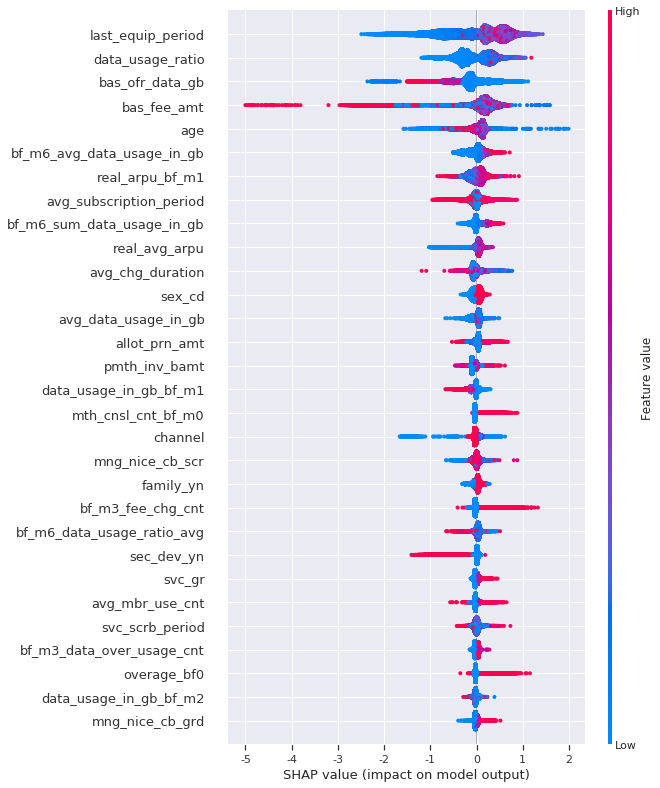

In [100]:
sm.summary_plot(max_display=30)

In [98]:
shap_rank()

svc_mgmt_num:  7305105742
calculate predict score by your self
model prediction score is : 0.0 
real target value was [0]


svc_mgmt_num                         col  shap_value  abs_shap_value  \
6    7305105742           last_equip_period   -1.150787        1.150787   
7    7305105742                 bas_fee_amt    0.184795        0.184795   
22   7305105742                    ansim_yn    0.164670        0.164670   
1    7305105742                         age    0.147196        0.147196   
50   7305105742           bf_m3_fee_chg_cnt    0.146589        0.146589   
8    7305105742             bas_ofr_data_gb   -0.138703        0.138703   
10   7305105742               allot_prn_amt   -0.130110        0.130110   
3    7305105742             mng_nice_cb_scr   -0.124179        0.124179   
44   7305105742     avg_subscription_period    0.101696        0.101696   
11   7305105742               pmth_inv_bamt   -0.085518        0.085518   
12   7305105742                   family_yn   -0.084862        0.084862   
0    7305105742                      sex_cd   -0.078392        0.078392   
54   7305105742  bf_m6_data_usage_ratio_avg    0.061251        0.061251   
46   7305105742             real_arpu_bf_m1    0.056660        0.056660   
47   7305105742             real_arpu_bf_m2    0.054625        0.054625   
27   7305105742      data_usage_in_gb_bf_m1   -0.054093        0.054093   
56   7305105742   bf_m3_data_over_usage_cnt   -0.051603        0.051603   
28   7305105742      data_usage_in_gb_bf_m2   -0.045467        0.045467   
4    7305105742             mng_nice_cb_grd   -0.045138        0.045138   
2    7305105742                      svc_gr   -0.038653        0.038653   
51   7305105742  bf_m6_sum_data_usage_in_gb   -0.037616        0.037616   
49   7305105742               real_avg_arpu    0.032592        0.032592   
78   7305105742                     channel   -0.030347        0.030347   
69   7305105742          mth_cnsl_cnt_bf_m0   -0.030004        0.030004   
52   7305105742  bf_m6_avg_data_usage_in_gb   -0.027807        0.027807   
57   7305105742           copn_left_cnt_bf0    0.026074        0.026074   
30   7305105742                 overage_bf0   -0.025640        0.025640   
53   7305105742            data_usage_ratio    0.023600        0.023600   
43   7305105742             avg_mbr_use_cnt   -0.023470        0.023470   
33   7305105742       copn_data_u1_yn_bf_m0   -0.020755        0.020755   

       real_value  
6       28.000000  
7    33000.000000  
22       1.000000  
1       44.000000  
50       1.000000  
8        1.500000  
10  658608.000000  
3      933.000000  
44   -9999.000000  
11  633838.000000  
12       1.000000  
0        0.000000  
54       0.773824  
46   25158.000000  
47       0.000000  
27       1.057160  
56       0.000000  
28       0.000000  
4        1.000000  
2        1.000000  
51       2.321472  
49   25158.000000  
78       3.000000  
69       0.000000  
52       1.160736  
57       0.000000  
30       0.000000  
53       0.842875  
43       0.000000  
33       0.000000

In [66]:
df_melt_value = pd.melt(sm.sample_df, id_vars=['svc_mgmt_num'], value_vars=feature_cols)

In [70]:
df_melt_value

svc_mgmt_num variable  value
0         7290234760   sex_cd    0.0
1         7294118735   sex_cd    0.0
2         7276845188   sex_cd    0.0
3         7296866635   sex_cd    1.0
4         7215900596   sex_cd    1.0
...              ...      ...    ...
7899916   7043319721  channel    1.0
7899917   7283759751  channel    1.0
7899918   7263794100  channel    3.0
7899919   7242535831  channel    1.0
7899920   7217841651  channel    3.0

[7899921 rows x 3 columns]